# <font color='black'>Importing Libraries</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#!pip install tensorflow-gpu==2.9.0
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import keras
import time
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm_notebook
from os import listdir
from pylab import rcParams
import tqdm.gui as tqdm
import tqdm.notebook as tqdm

Mounted at /content/drive


In [ ]:
print(tf.__version__)

2.9.0


In [ ]:
!cd /content/Dataset

! unzip /content/drive/MyDrive/Dataset/ProcessedDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ProcessedTraining/glioma_tumor/gg (772).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (773).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (774).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (775).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (776).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (777).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (778).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (779).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (78).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (780).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (781).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (782).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (783).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (784).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (785).jpg  
  inflating: ProcessedTraining/glioma_tumor/gg (786).jpg  
  infl

# <font color='black'>Function for Preparing and Augmenting Image Data</font>

This function augments the data for training and validation.
- Inputs
    - path_TrainingData: Path to the dataset for training and validation
    - path_TestData: Path to the dataset for testing
    - tSize: Target size for the generator to resize all images to (224,224)
    - bsize: Batch size
    - cMode: Class mode, 'categorical'
    - shuffling: A boolean value whether to enable shuffling of validation data
<br><br>
- Outputs
    - data_Train: Augmented training data
    - data_Val: Image dataset for validation
    - data_Test: Image dataset for testing


In [ ]:
def data_Generator(path_TrainingData, path_TestData, tSize, bSize, cMode, shuffling):

    dataGen_Train = ImageDataGenerator(horizontal_flip = True,
                                       vertical_flip = True,
                                       #rotation_range = 10, # rotation
                                       #width_shift_range = 0.2, # horizontal shift
                                       #height_shift_range = 0.2, # vertical shift
                                       #fill_mode='nearest',
                                       validation_split = 0.2)

    dataGen_Val = ImageDataGenerator(validation_split = 0.2)
    dataGen_Test = ImageDataGenerator()

    data_Train = dataGen_Train.flow_from_directory(path_TrainingData,
                                                   seed = 42,
                                                   target_size = tSize,
                                                   color_mode = 'rgb',
                                                   batch_size = bSize,
                                                   class_mode = cMode,
                                                   shuffle = True,
                                                   subset='training')

    data_Val = dataGen_Val.flow_from_directory(path_TrainingData,
                                               seed = 42,
                                               target_size = tSize,
                                               color_mode = 'rgb',
                                               batch_size = bSize,
                                               class_mode = cMode,
                                               shuffle = shuffling,
                                               subset='validation')

    data_Test = dataGen_Test.flow_from_directory(path_TestData,
                                                 target_size = tSize,
                                                 color_mode = 'rgb',
                                                 batch_size = 1,
                                                 class_mode = cMode,
                                                 shuffle = False)

    return data_Train, data_Val, data_Test

# <font color='black'>Function for Training the Model, Then Perform Predictions and Evaluation</font>

This function trains the model and return the accuracy of the model.
- Inputs
    - data_Train: generated train data
    - data_Val: generated validation data
    - optimizer: the optimizer method used to compile the model
    - epochs: the epochs of the model use to fit the model
    - dropout_Value: the dropout value
    - baseModel: The pretrained model loaded,
<br><br>
- Outputs
    - accuracy: The accuracy of the model
    - model: The trained model

In [ ]:
def model_Train_Evaluate(data_Train, data_Val, optimizer, epochs, dropout_Value, input_Shape):

    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=input_Shape))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(128, activation='relu'))
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))
    cnn.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Compiling the model
    cnn.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    step_size_train = data_Train.n // data_Train.batch_size

    # Fitting the model
    cnn.fit(data_Train,
              validation_data = data_Val,
              steps_per_epoch = step_size_train,
              epochs = epochs)

    # Evaluating the model
    history = cnn.history.history
    scores = cnn.evaluate(data_Val)
    accuracy = scores[1]*100

    return accuracy, cnn, history

# <font color='black'>Function for Plotting the Graph of Model Loss and Accuracy</font>

In [ ]:
def plot_Metrics(history):

    train_Loss = history['loss']
    val_Loss = history['val_loss']
    train_Acc = history['accuracy']
    val_Acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_Loss, label='Training Loss')
    plt.plot(val_Loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_Acc, label='Training Accuracy')
    plt.plot(val_Acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


# <font color='black'>Exploring the Image Dataset</font>

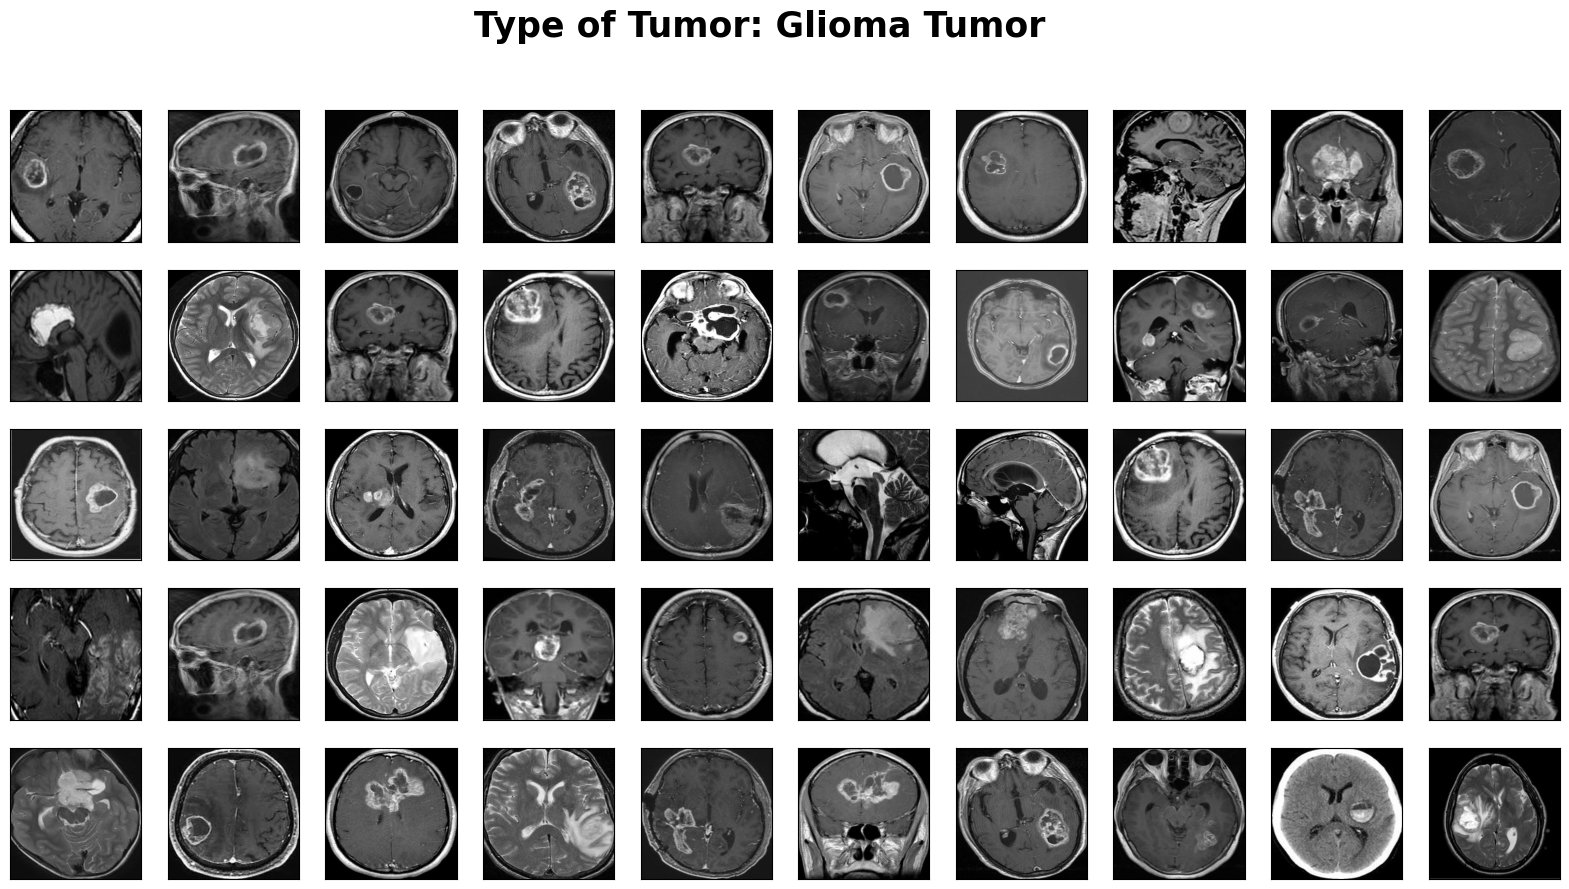

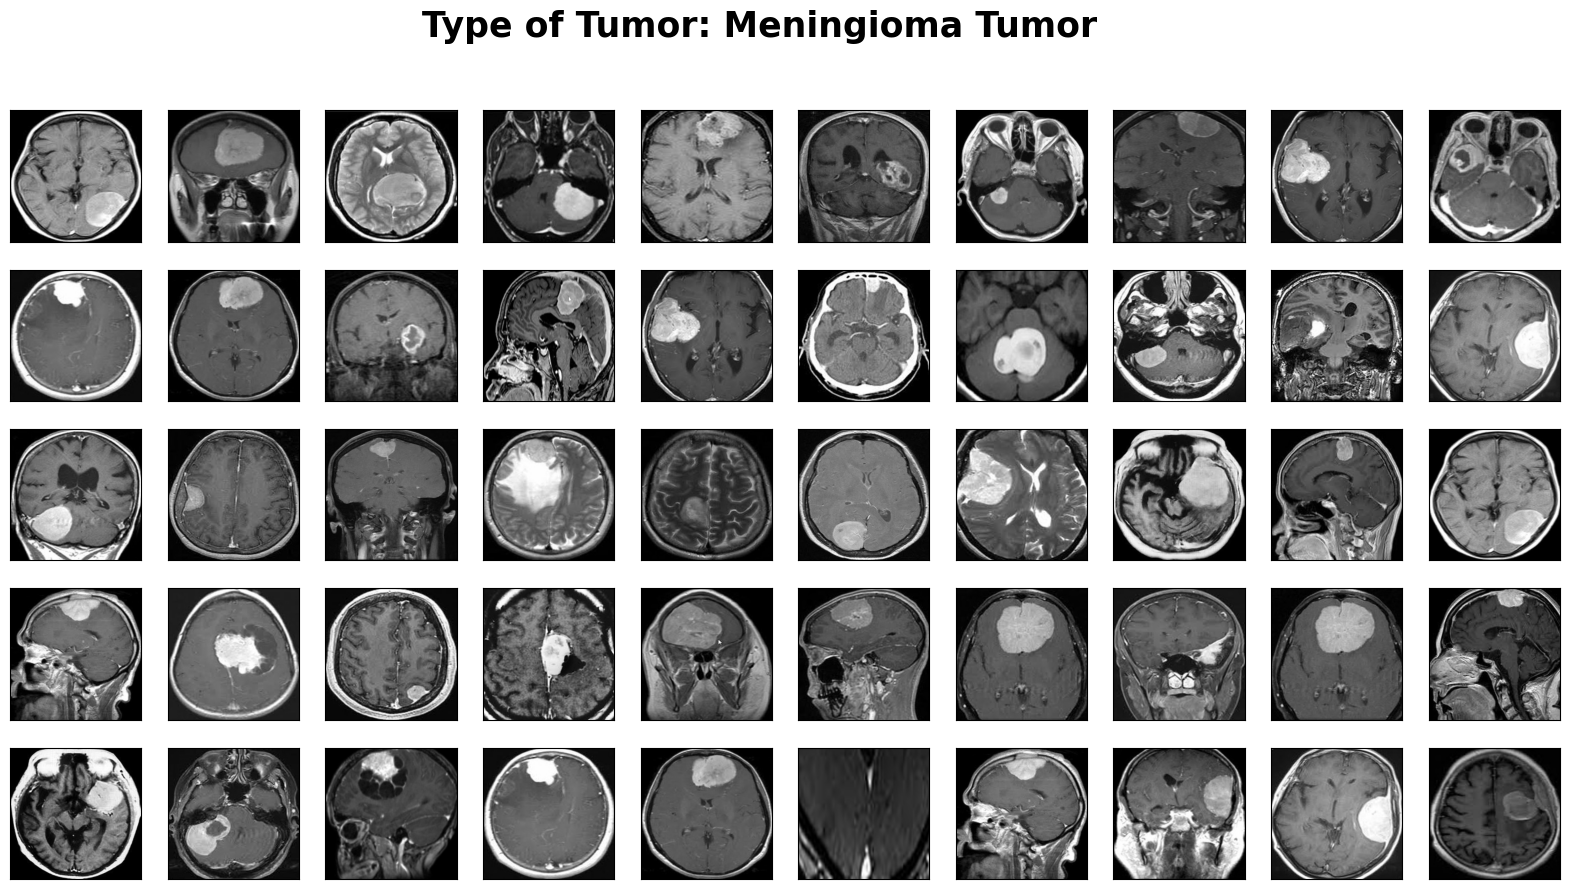

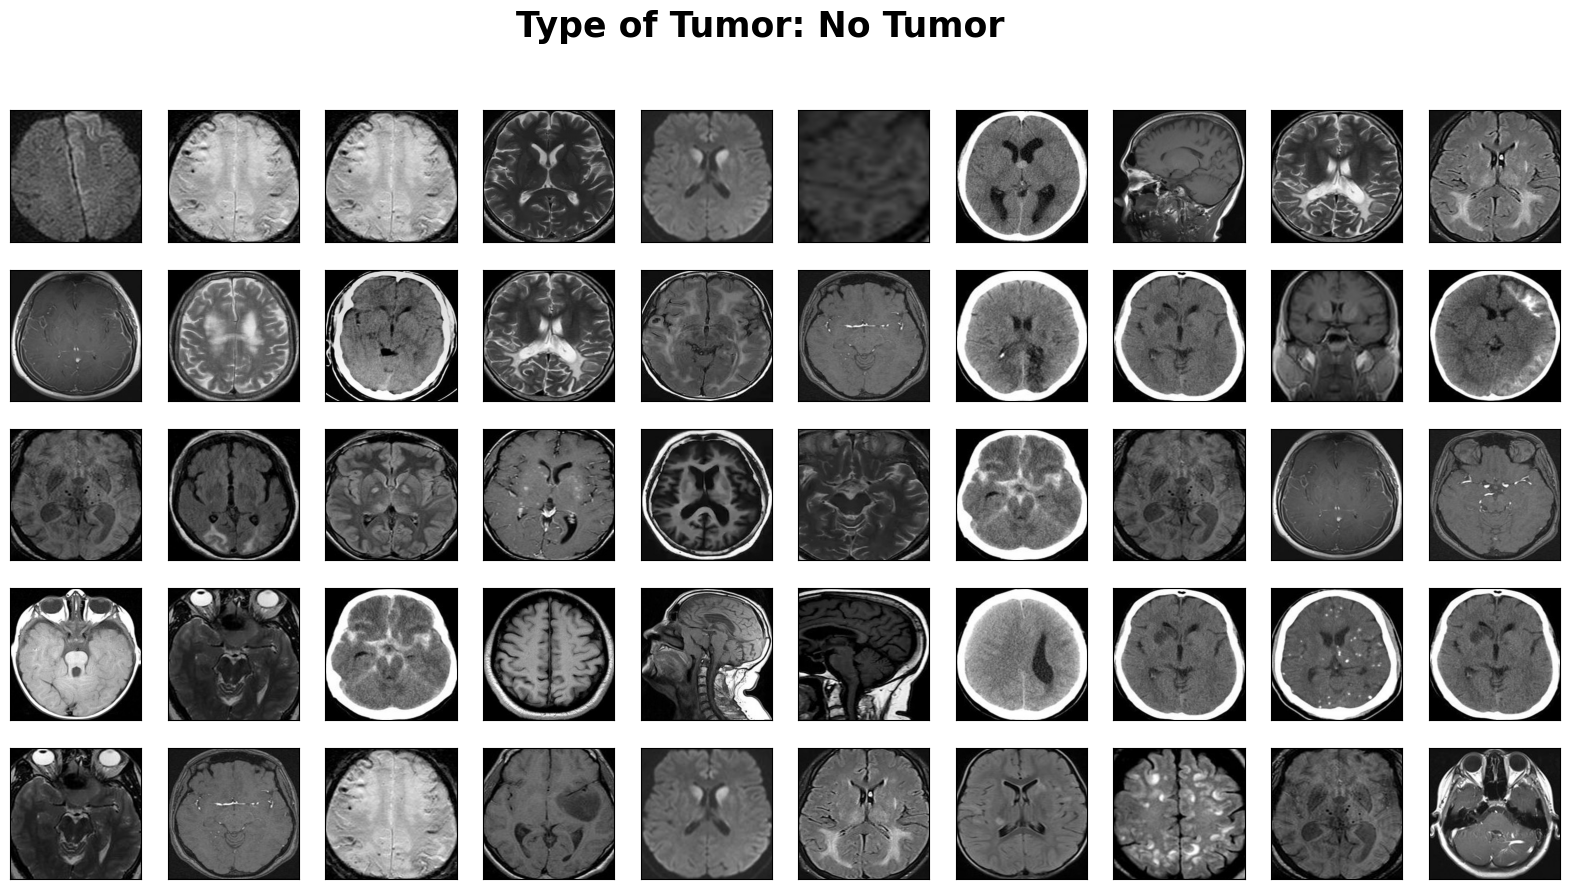

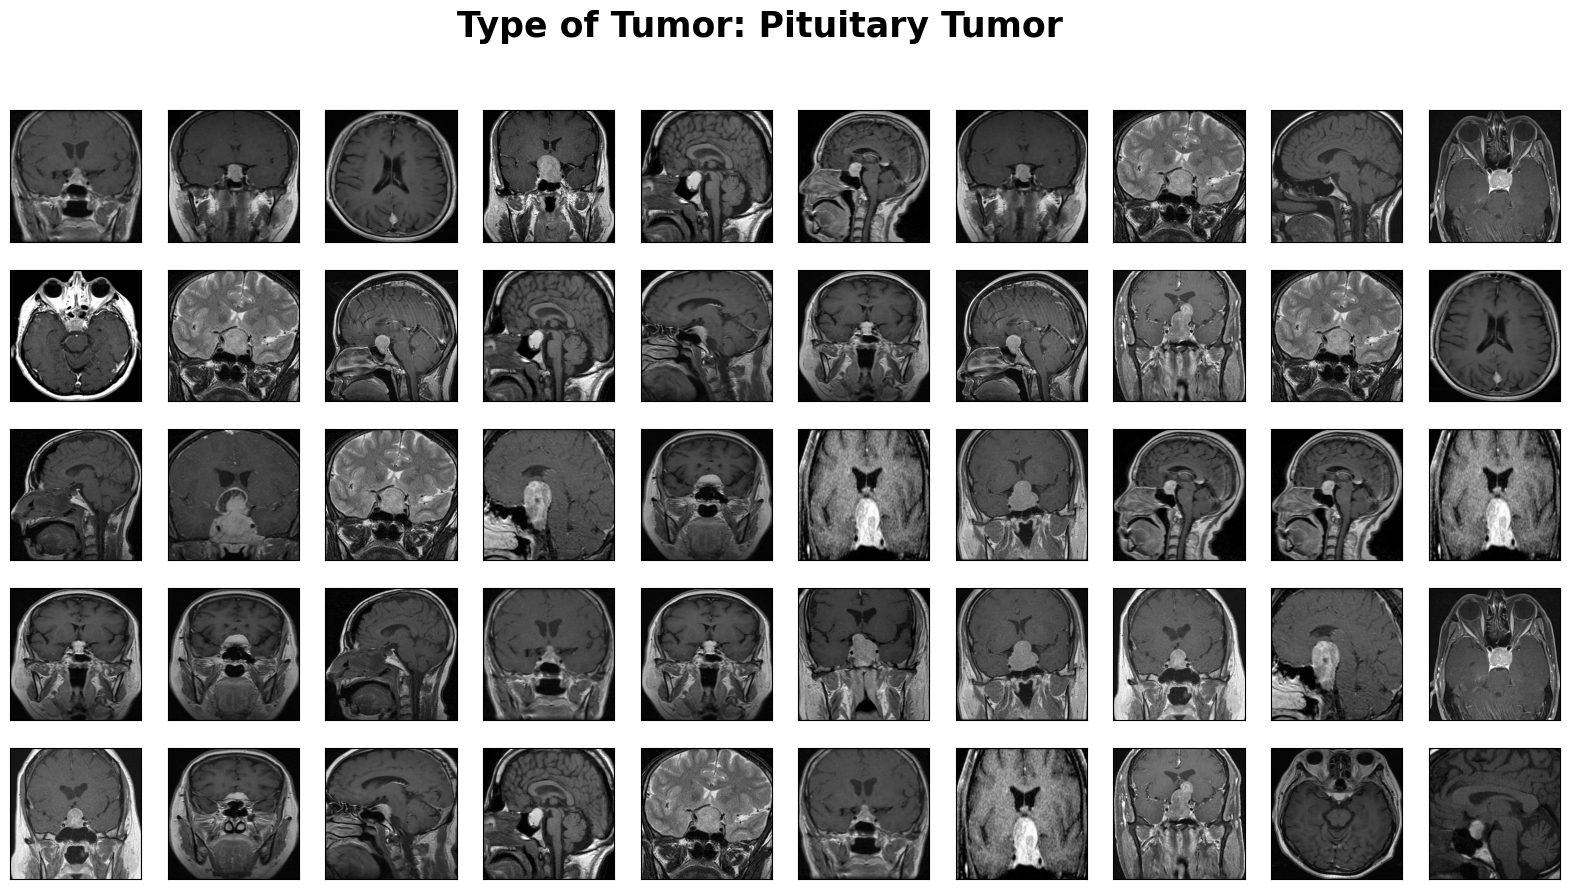

In [ ]:
#dir_list = ['ProcessedTraining/glioma_tumor', 'ProcessedTraining/meningioma_tumor', 'ProcessedTraining/no_tumor', 'ProcessedTraining/pituitary_tumor']
# https://drive.google.com/drive/folders/1X6GgRu3Q_T-XJElZUvI-YhkMIDKcyFsv?usp=sharing
# dir_list = ['/content/drive/My Drive/Dataset/ProcessedTraining/glioma_tumor',
#             '/content/drive/My Drive/Dataset/ProcessedTraining/meningioma_tumor',
#             '/content/drive/My Drive/Dataset/ProcessedTraining/no_tumor',
#             '/content/drive/My Drive/Dataset/ProcessedTraining/pituitary_tumor']

dir_list = ['/content/ProcessedTesting/glioma_tumor', '/content/ProcessedTesting/meningioma_tumor', '/content/ProcessedTesting/no_tumor', '/content/ProcessedTesting/pituitary_tumor']
n = 50

for directory in dir_list:
    columns_n = 10
    rows_n = int(n/ columns_n)

    plt.figure(figsize=(20, 10))

    i = 1

    for filename in listdir(directory):
        # load the image
        image = cv2.imread(directory + '/' + filename)

        plt.subplot(rows_n, columns_n, i)
        plt.imshow(image)

        # remove ticks
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                       labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        i += 1
        if i > 50:
            break
        else:
            continue

    i = 1
    tumor_Type = directory.rsplit('/', 1)[-1]
    formatted_Text = ''

    if tumor_Type == "glioma_tumor":
            formatted_Text = "Glioma Tumor"
    elif tumor_Type == "meningioma_tumor":
            formatted_Text = "Meningioma Tumor"
    elif tumor_Type == "no_tumor":
            formatted_Text = "No Tumor"
    elif tumor_Type == "pituitary_tumor":
            formatted_Text = "Pituitary Tumor"


    plt.suptitle(f"Type of Tumor: {formatted_Text}", fontweight ="bold", fontsize = 25)
    plt.show()

# <font color='black'>1.0 Load and Generate Image Data</font>

In [ ]:
# Constant parameters
tSize_Constant = (224,224)
cMode_Constant = 'categorical'

# Default parameters
bSize_Initial = 8
dropout_Value_Initial = 0.1
epochs_Initial = 4
optimizer_Initial = 'Adam'

# Data paths
# path_TrainingData = '/content/drive/My Drive/Dataset/ProcessedTraining/'
# path_ValidationData = '/content/drive/My Drive/Dataset/ProcessedValidation/'
# path_testData = '/content/drive/My Drive/Dataset/ProcessedTesting/'
path_TrainingData = '/content/ProcessedTraining'
#path_ValidationData = '/content/ProcessedValidation'
path_testData = '/content/ProcessedTesting'

data_Train_Initial, data_Val_Initial, data_Test_Initial = data_Generator(path_TrainingData,
                                                                         path_testData,
                                                                         tSize_Constant,
                                                                         bSize_Initial,
                                                                         cMode_Constant,
                                                                         True)

# Display the classes found in the dataset
data_Train_Initial.class_indices

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# <font color='black'>2.0 Preparing the EfficientNetB7 Base Model</font>

## <font color='black'>2.1 Building the Model</font>

In [ ]:
image_size = (224,224,3)

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=image_size))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation='relu'))
cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(4, activation='softmax'))

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 48)      1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 48)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 48)      20784     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        13856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

## <font color='black'>2.2 Compiling the Model</font>

In [ ]:
cnn.compile(optimizer = optimizer_Initial,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## <font color='black'>2.4 Fitting the Model</font>

In [ ]:
# Computing the steps size per epoch
sSize_Train_Initial = data_Train_Initial.n // data_Train_Initial.batch_size

tic = time.time()

# Fitting the model
cnn.fit(data_Train_Initial,
        validation_data = data_Val_Initial,
        steps_per_epoch = sSize_Train_Initial,
        epochs = epochs_Initial)

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
model_Initial_History = cnn.history.history
scores = cnn.evaluate(data_Val_Initial)
accuracy = scores[1]*100
accuracy

Epoch 1/4
287/287 [==============================] - 16s 27ms/step - loss: 2.4330 - accuracy: 0.3639 - val_loss: 1.3965 - val_accuracy: 0.2880
Epoch 2/4
287/287 [==============================] - 7s 24ms/step - loss: 1.2570 - accuracy: 0.3976 - val_loss: 1.3808 - val_accuracy: 0.2304
Epoch 3/4
287/287 [==============================] - 7s 25ms/step - loss: 1.1849 - accuracy: 0.4683 - val_loss: 1.3138 - val_accuracy: 0.2845
Epoch 4/4
287/287 [==============================] - 7s 24ms/step - loss: 1.1436 - accuracy: 0.5015 - val_loss: 1.3130 - val_accuracy: 0.3508
Minutes taken = 0.6861504435539245
72/72 [==============================] - 1s 18ms/step - loss: 1.3130 - accuracy: 0.3508


35.07853448390961

### <font color='black'>Loss and Accuracy of the Initial Model</font>

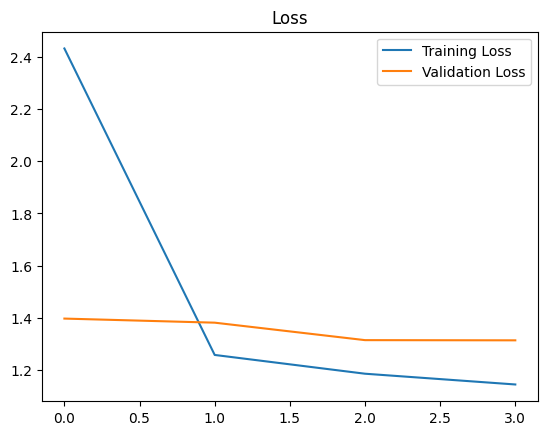

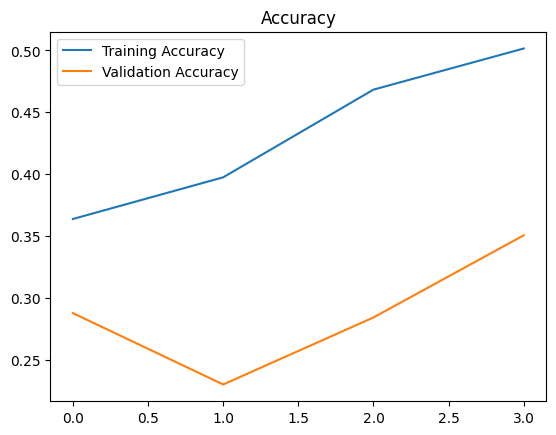

In [ ]:
plot_Metrics(model_Initial_History)

### <font color='black'>Confusion Matrix</font>

394/394 [==============================] - 1s 3ms/step


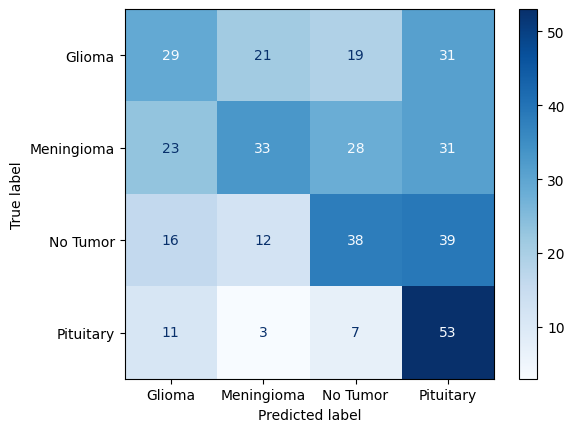

In [ ]:
Y_pred = cnn.predict(data_Test_Initial, data_Test_Initial.n)
y_pred = np.argmax(Y_pred, axis = 1)
cm = confusion_matrix(data_Test_Initial.classes, y_pred)

# 'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3
target_Names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_Names)

disp.plot(cmap = plt.cm.Blues)
plt.show()

### <font color='black'>Classification Report</font>

In [ ]:
print(classification_report(data_Test_Initial.classes, y_pred, target_names = target_Names))

              precision    recall  f1-score   support

      Glioma       0.37      0.29      0.32       100
  Meningioma       0.48      0.29      0.36       115
    No Tumor       0.41      0.36      0.39       105
   Pituitary       0.34      0.72      0.46        74

    accuracy                           0.39       394
   macro avg       0.40      0.41      0.38       394
weighted avg       0.41      0.39      0.38       394



# <font color='black'>3.0 Fine Tuning the Model</font>

## <font color='black'>3.1 Selecting the Best Optimizer for the Model</font>

In [ ]:
param_Label = 'Optimizer'
param_List = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta'] # ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta']

accuracy_Table = {param_Label: [], 'Accuracy': []}
tic = time.time()

for param in tqdm.tqdm_notebook(param_List):
    # Training, predicting and evaluating the model
    accuracy, _, _ = model_Train_Evaluate(data_Train_Initial, data_Val_Initial, param, epochs_Initial, dropout_Value_Initial, image_size) # replace epochs with 'epochs_initial'

    # Collecting results
    accuracy_Table[param_Label].append(param)
    accuracy_Table['Accuracy'].append(accuracy)

accuracy_Table = pd.DataFrame(accuracy_Table) # Converting the table into a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_Table # Displaying the result

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/4
287/287 [==============================] - 8s 25ms/step - loss: 2.9761 - accuracy: 0.3727 - val_loss: 1.3875 - val_accuracy: 0.2513
Epoch 2/4
287/287 [==============================] - 9s 30ms/step - loss: 1.2528 - accuracy: 0.4325 - val_loss: 1.3042 - val_accuracy: 0.3403
Epoch 3/4
287/287 [==============================] - 7s 26ms/step - loss: 1.1763 - accuracy: 0.4666 - val_loss: 1.2882 - val_accuracy: 0.3490
Epoch 4/4
72/72 [==============================] - 1s 17ms/step - loss: 1.4292 - accuracy: 0.2548
Epoch 1/4
287/287 [==============================] - 7s 24ms/step - loss: nan - accuracy: 0.2857 - val_loss: nan - val_accuracy: 0.2880
Epoch 2/4
287/287 [==============================] - 7s 26ms/step - loss: nan - accuracy: 0.2883 - val_loss: nan - val_accuracy: 0.2880
Epoch 3/4
287/287 [==============================] - 7s 24ms/step - loss: nan - accuracy: 0.2875 - val_loss: nan - val_accuracy: 0.2880
Epoch 4/4
72/72 [==============================] - 1s 17ms/step - lo

Optimizer   Accuracy
0      Adam  25.479931
1       SGD  28.795812
2   RMSprop  47.294939
3   Adagrad  49.563700
4  Adadelta  31.239092

### <font color='black'>Plotting the Results in a Graph</font>

Text(0, 0.5, 'Accuracy')

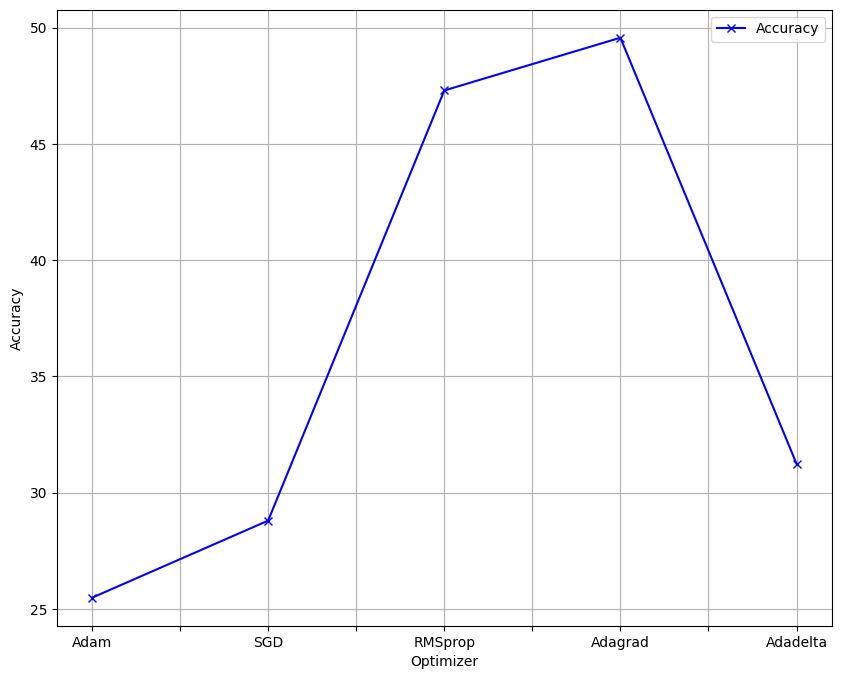

In [ ]:
# Plotting the graph
rcParams['figure.figsize'] = 10, 8 # width of 10 and height of 8

ax = accuracy_Table.plot(x = 'Optimizer', y = 'Accuracy', style = 'bx-', grid = True)
ax.set_xlabel("Optimizer")
ax.set_ylabel("Accuracy")

### <font color='black'>Getting the Optimum Optimizer</font>

In [ ]:
temp = accuracy_Table[accuracy_Table['Accuracy'] == accuracy_Table['Accuracy'].max()]
optimizer_Opt = temp[param_Label].values[0]
print("Max Accuracy = %0.3f" % accuracy_Table['Accuracy'].max())
print("Optimum " + param_Label + " = " + str(optimizer_Opt))

Max Accuracy = 49.564
Optimum Optimizer = Adagrad


## <font color='black'>3.2 Determining the Good Dropout Rate for the Model</font>

In [ ]:
param_Label = 'Dropout Rate'
param_List = [0.5, 0.6, 0.7, 0.8, 0.9]


accuracy_Table = {param_Label: [], 'Accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_List):

    accuracy, _, _ = model_Train_Evaluate(data_Train_Initial, data_Val_Initial, optimizer_Initial, epochs_Initial, param, image_size)

    accuracy_Table[param_Label].append(param)
    accuracy_Table['Accuracy'].append(accuracy)

accuracy_Table = pd.DataFrame(accuracy_Table)
toc = time.time()
print("Minutes Taken = " + str((toc-tic)/60.0))
accuracy_Table

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: ignored

### <font color='black'>Plotting the Results in a Graph</font>

Text(0, 0.5, 'Accuracy')

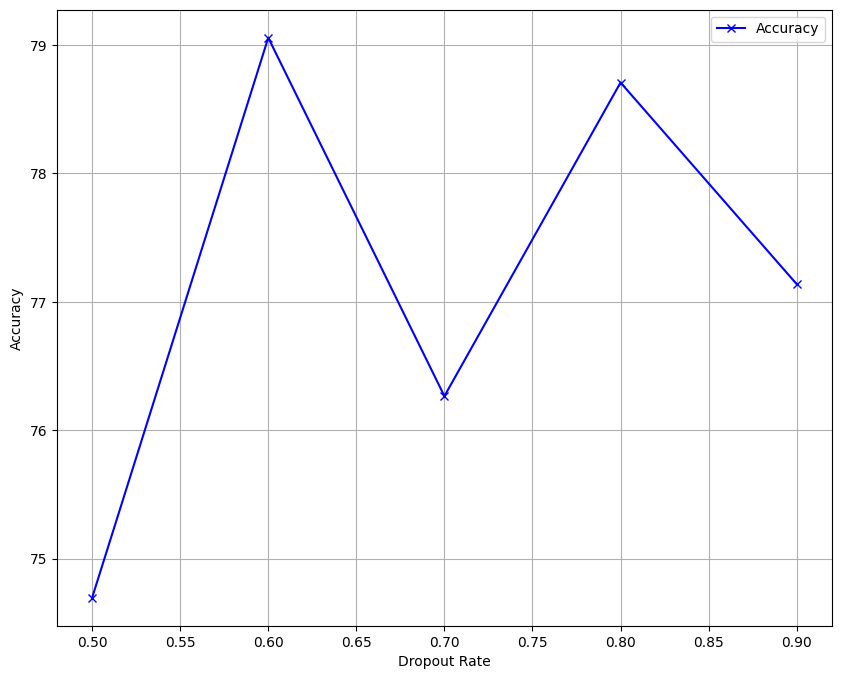

In [ ]:
rcParams['figure.figsize'] = 10,8

ax = accuracy_Table.plot(x = 'Dropout Rate', y = 'Accuracy', style = 'bx-', grid = True)
ax.set_xlabel("Dropout Rate")
ax.set_ylabel("Accuracy")

### <font color='black'>Getting the Best Value for Dropout Rate</font>

In [ ]:
temp = accuracy_Table[accuracy_Table['Accuracy'] == accuracy_Table['Accuracy'].max()]
dropout_Opt = temp[param_Label].values[0]
print("Max Accuracy = %0.3f" % accuracy_Table['Accuracy'].max())
print("Optimum " + param_Label + " = " + str(dropout_Opt))

Max Accuracy = 79.058
Optimum Dropout Rate = 0.6


## <font color='black'>3.3 Determining the Optimum Epochs and Batch Size </font>

In [ ]:
param_Label = 'Epochs'
param_List = [5, 10, 15, 20]

param2_Label = 'Batch Size'
param2_List = [8, 16, 32, 64]

accuracy_Table = {param_Label: [], param2_Label: [], 'Accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_List):
    for param2 in tqdm_notebook(param2_List):

        # Preparing the data with a different batch size compared to the initial one
        data_Train, data_Val, _ = data_Generator(path_TrainingData, path_testData, tSize_Constant, param2, cMode_Constant, True)

        accuracy, _, _ = model_Train_Evaluate(data_Train, data_Val, optimizer_Initial, param, dropout_Value_Initial, image_size)

        accuracy_Table[param_Label].append(param)
        accuracy_Table[param2_Label].append(param2)
        accuracy_Table['Accuracy'].append(accuracy)

accuracy_Table = pd.DataFrame(accuracy_Table)
toc = time.time()
print("Minutes Taken = " + str((toc-tic)/60.0))
accuracy_Table

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-18-b2d0516e0998>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_List):


  0%|          | 0/4 [00:00<?, ?it/s]

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
287/287 [==============================] - 9s 28ms/step - loss: 2.0582 - accuracy: 0.4163 - val_loss: 1.4246 - val_accuracy: 0.3141
Epoch 2/5
287/287 [==============================] - 7s 23ms/step - loss: 1.1138 - accuracy: 0.5277 - val_loss: 1.3247 - val_accuracy: 0.2635
Epoch 3/5
287/287 [==============================] - 8s 27ms/step - loss: 1.0004 - accuracy: 0.5902 - val_loss: 1.2042 - val_accuracy: 0.4695
Epoch 4/5
287/287 [==============================] - 7s 24ms/step - loss: 0.8650 - accuracy: 0.6571 - val_loss: 1.1926 - val_accuracy: 0.4555
Epoch 5/5
72/72 [==============================] - 1s 18ms/step - loss: 1.5599 - accuracy: 0.4049
Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
143/143 [==============================] - 9s 53ms/step - loss: 2.6052 - acc

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/10
287/287 [==============================] - 7s 24ms/step - loss: 3.2228 - accuracy: 0.3648 - val_loss: 1.3341 - val_accuracy: 0.3630
Epoch 2/10
287/287 [==============================] - 8s 26ms/step - loss: 1.1284 - accuracy: 0.5111 - val_loss: 1.3763 - val_accuracy: 0.3298
Epoch 3/10
287/287 [==============================] - 7s 24ms/step - loss: 0.9641 - accuracy: 0.5959 - val_loss: 1.1758 - val_accuracy: 0.4590
Epoch 4/10
287/287 [==============================] - 7s 26ms/step - loss: 0.8563 - accuracy: 0.6435 - val_loss: 1.7895 - val_accuracy: 0.3264
Epoch 5/10
287/287 [==============================] - 8s 28ms/step - loss: 0.7902 - accuracy: 0.6894 - val_loss: 1.3687 - val_accuracy: 0.4485
Epoch 6/10
287/287 [==============================] - 7s 26ms/step - loss: 0.6893 - accuracy: 0.7283 - val_loss: 1.5470 - val_accuracy: 0.3490
Epoch 7/10
287/287

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/15
287/287 [==============================] - 8s 27ms/step - loss: 2.2952 - accuracy: 0.3652 - val_loss: 1.4144 - val_accuracy: 0.2583
Epoch 2/15
287/287 [==============================] - 8s 27ms/step - loss: 1.2032 - accuracy: 0.4526 - val_loss: 1.3264 - val_accuracy: 0.3229
Epoch 3/15
287/287 [==============================] - 7s 24ms/step - loss: 1.0851 - accuracy: 0.5299 - val_loss: 1.3171 - val_accuracy: 0.3386
Epoch 4/15
287/287 [==============================] - 8s 27ms/step - loss: 0.9919 - accuracy: 0.5762 - val_loss: 2.0847 - val_accuracy: 0.2757
Epoch 5/15
287/287 [==============================] - 7s 25ms/step - loss: 0.8602 - accuracy: 0.6391 - val_loss: 1.3537 - val_accuracy: 0.4433
Epoch 6/15
287/287 [==============================] - 7s 26ms/step - loss: 0.7141 - accuracy: 0.7134 - val_loss: 1.4309 - val_accuracy: 0.4346
Epoch 7/15
287/287

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/20
287/287 [==============================] - 8s 24ms/step - loss: 2.9794 - accuracy: 0.3591 - val_loss: 1.5088 - val_accuracy: 0.2408
Epoch 2/20
287/287 [==============================] - 8s 26ms/step - loss: 1.2132 - accuracy: 0.4382 - val_loss: 1.4024 - val_accuracy: 0.2810
Epoch 3/20
287/287 [==============================] - 7s 24ms/step - loss: 1.1170 - accuracy: 0.5098 - val_loss: 1.5282 - val_accuracy: 0.2356
Epoch 4/20
287/287 [==============================] - 7s 26ms/step - loss: 1.0000 - accuracy: 0.5784 - val_loss: 1.2519 - val_accuracy: 0.4328
Epoch 5/20
287/287 [==============================] - 7s 24ms/step - loss: 0.8773 - accuracy: 0.6374 - val_loss: 1.4570 - val_accuracy: 0.3455
Epoch 6/20
287/287 [==============================] - 7s 25ms/step - loss: 0.7338 - accuracy: 0.6994 - val_loss: 1.2760 - val_accuracy: 0.4468
Epoch 7/20
287/287

Epochs  Batch Size   Accuracy
0        5           8  40.488657
1        5          16  52.705061
2        5          32  44.677138
3        5          64  54.101223
4       10           8  50.436300
5       10          16  46.945900
6       10          32  46.247819
7       10          64  52.530539
8       15           8  48.167539
9       15          16  49.389181
10      15          32  49.738219
11      15          64  41.884816
12      20           8  54.450262
13      20          16  55.846423
14      20          32  45.724258
15      20          64  69.808030

### <font color='black'>Plotting the Results in Graphs</font>

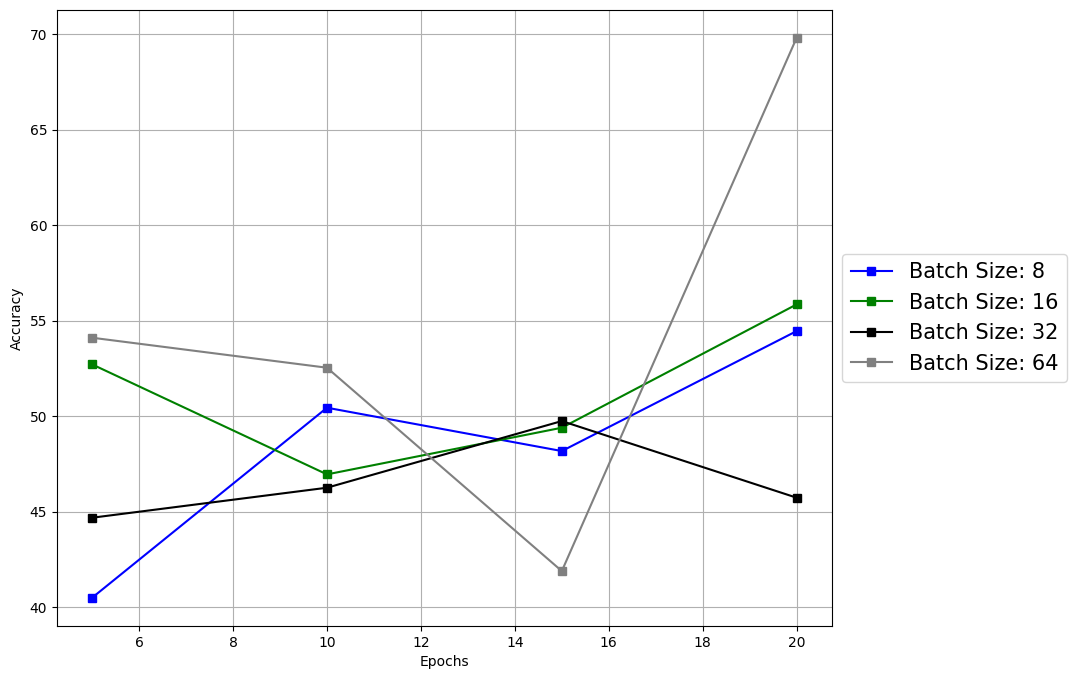

In [ ]:
rcParams['figure.figsize'] = 10, 8
temp = accuracy_Table[accuracy_Table[param2_Label]==param2_List[0]]
ax = temp.plot(x = param_Label, y = 'Accuracy', style = 'bs-', grid = True)
legend_List = [param2_Label + ': ' + str(param2_List[0])]

color_List = ['r', 'g', 'k', '0.5']
for i in range(1, len(param2_List)):
    temp = accuracy_Table[accuracy_Table[param2_Label] == param2_List[i]]
    ax = temp.plot(x = param_Label, y = 'Accuracy', color = color_List[i % len(color_List)], marker = 's', grid = True, ax = ax)
    legend_List.append(param2_Label + ': ' + str(param2_List[i]))

ax.set_xlabel(param_Label)
ax.set_ylabel("Accuracy")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_List, loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 15}) # Positioning the legend to be outside of the figure

### <font color='black'>Getting the Optimum Value for Both Epochs and Batch Size</font>

In [ ]:
temp = accuracy_Table[accuracy_Table['Accuracy'] == accuracy_Table['Accuracy'].max()]
epochs_Opt = temp[param_Label].values[0]
bSize_Opt = temp[param2_Label].values[0]
print("Max Accuracy = %0.3f" % accuracy_Table['Accuracy'].max())
print("Optimum " + param_Label + " = " + str(epochs_Opt))
print("Optimum " + param2_Label + " = " + str(bSize_Opt))

Max Accuracy = 69.808
Optimum Epochs = 20
Optimum Batch Size = 64


### <font color='black'>Gathering the Optimum Value for All the Hyperparameters</font>

In [ ]:
dropout_Opt = 0.6
# optimizer_Opt = 'Adam'
# bSize_Opt = 16
# epochs_Opt = 15

dCollected = {'Hyperparameters': ['Optimizer', 'Epochs', 'Batch Size'],
              'Initial': [optimizer_Initial, epochs_Initial, bSize_Initial],
              'Optimum': [optimizer_Opt, epochs_Opt, bSize_Opt]}

opt_Params = pd.DataFrame(dCollected)
opt_Params

Hyperparameters Initial  Optimum
0       Optimizer    Adam  Adagrad
1          Epochs       4       20
2      Batch Size       8       64

# <font color='black'>4.0 Model Finalization with Optimum Value of All Hyperparameters</font>

In [ ]:
data_Train_Opt, data_Val_Opt, data_Test_Opt = data_Generator(path_TrainingData, path_testData, tSize_Constant, bSize_Opt, cMode_Constant, True)

accuracy, final_Model, model_History = model_Train_Evaluate(data_Train_Opt, data_Val_Opt, optimizer_Opt, epochs_Opt, dropout_Opt, image_size)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/20
35/35 [==============================] - 9s 248ms/step - loss: 5.6166 - accuracy: 0.3686 - val_loss: 1.4382 - val_accuracy: 0.2967
Epoch 2/20
35/35 [==============================] - 9s 247ms/step - loss: 1.1214 - accuracy: 0.5343 - val_loss: 1.3771 - val_accuracy: 0.3438
Epoch 3/20
35/35 [==============================] - 9s 254ms/step - loss: 0.9695 - accuracy: 0.6113 - val_loss: 1.4823 - val_accuracy: 0.3229
Epoch 4/20
35/35 [==============================] - 8s 234ms/step - loss: 0.8907 - accuracy: 0.6444 - val_loss: 1.2285 - val_accuracy: 0.4398
Epoch 5/20
35/35 [==============================] - 9s 250ms/step - loss: 0.8127 - accuracy: 0.6811 - val_loss: 1.2096 - val_accuracy: 0.4468
Epoch 6/20
35/35 [==============================] - 8s 231ms/step - loss: 0.7185 - accuracy: 0.7219 - val_loss: 1.1336 - val_accuracy: 0.4939
Epoch 7/20
35/35 [======

### <font color='black'>Loss and Accuracy of Final Model</font>

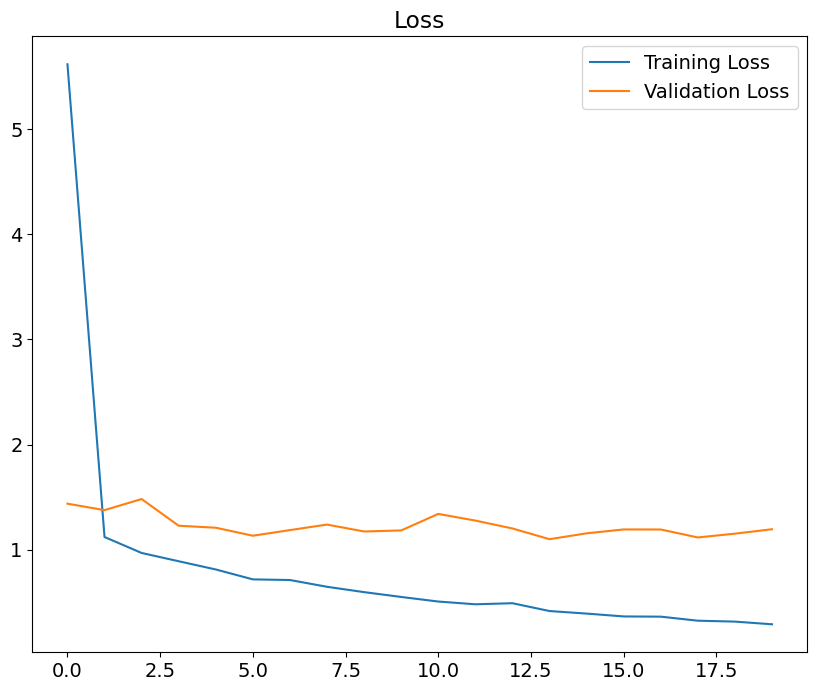

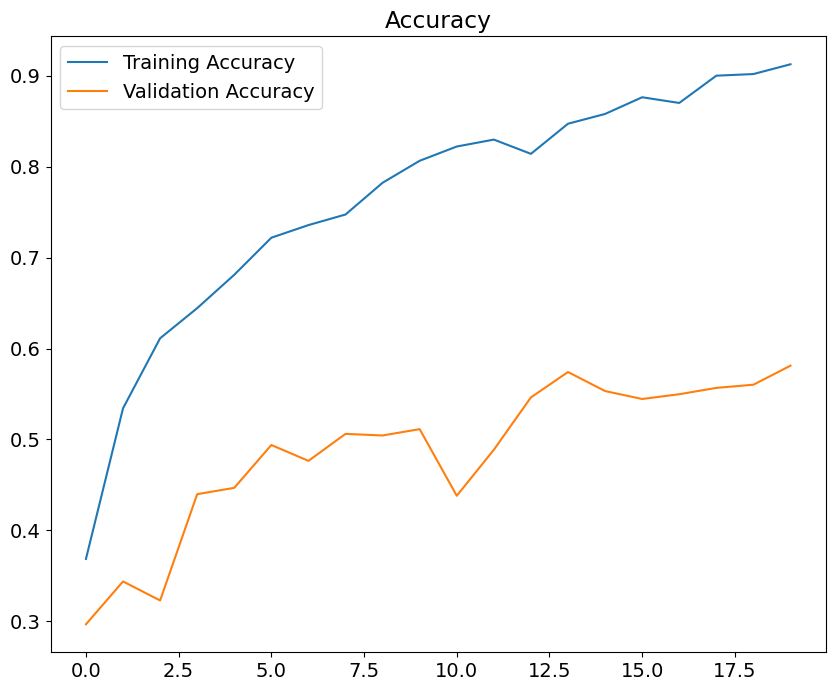

In [ ]:
#model_History = final_Model.history.history

plot_Metrics(model_History)

### <font color='black'>Confusion Matrix</font>

394/394 [==============================] - 1s 4ms/step


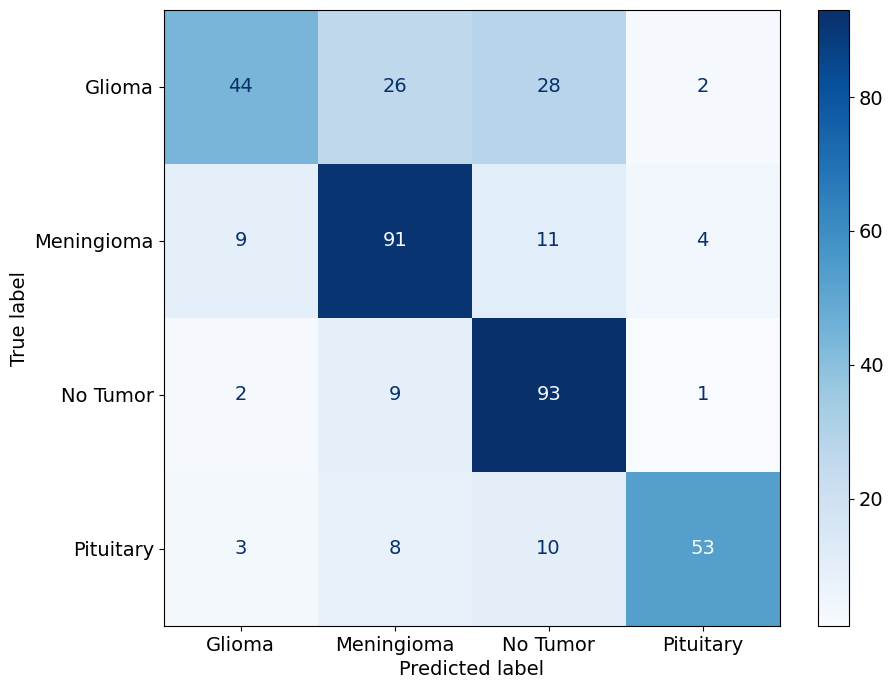

In [ ]:
#Confution Matrix and Classification Report
#Y_pred = model.predict_generator(data_Val_Initial, data_Val_Initial.n // data_Val_Initial.batch_size+1)
Y_pred = final_Model.predict(data_Test_Opt, data_Test_Opt.n)
y_pred = np.argmax(Y_pred, axis = 1)
cm = confusion_matrix(data_Test_Opt.classes, y_pred)

# 'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3
target_Names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_Names)

disp.plot(cmap = plt.cm.Blues)
plt.show()

### <font color='black'>Classification Report</font>

In [ ]:
print(classification_report(data_Test_Opt.classes, y_pred, target_names = target_Names))

              precision    recall  f1-score   support

      Glioma       0.76      0.44      0.56       100
  Meningioma       0.68      0.79      0.73       115
    No Tumor       0.65      0.89      0.75       105
   Pituitary       0.88      0.72      0.79        74

    accuracy                           0.71       394
   macro avg       0.74      0.71      0.71       394
weighted avg       0.73      0.71      0.70       394



In [ ]:
# !pip install tensorflow==2.9
# import tensorflow as tf
# print(tf.__version__)

final_Model.save('btc_cnn_final_model.hdf5')
final_Model.save_weights('btc_cnn_final_weights.h5')

In [ ]:
from google.colab import files
files.download('btc_cnn_final_model.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('btc_cnn_final_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!kill $(ps aux | awk '{print $2}')